In [1]:
import sys, os, json, random
import torch
import sys
import datetime

import cv2

import numpy as np
import pandas as pd

import skimage.io as io

import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = [16,9]
%matplotlib inline

from shapely.geometry import Polygon

# path to the images
data_dir = "C:/Users/kurt_/car-parts-and-damage-detection-v3/car-part-detection/car-part/File1"

# create paths for traininig and validaiton data
os.makedirs("C:/Users/kurt_/car-parts-and-damage-detection-v3/car-part-detection/working/data/", exist_ok=True)
os.makedirs("C:/Users/kurt_/car-parts-and-damage-detection-v3/car-part-detection/working/data/train/", exist_ok=True)
os.makedirs("C:/Users/kurt_/car-parts-and-damage-detection-v3/car-part-detection/working/data/val/", exist_ok=True)


# create path to store the model config
os.makedirs("C:/Users/kurt_/car-parts-and-damage-detection-v3/car-part-detection/working/model/", exist_ok=True)

data_working_dir = "C:/Users/kurt_/car-parts-and-damage-detection-v3/car-part-detection/working/data/"
model_dir = "C:/Users/kurt_/car-parts-and-damage-detection-v3/car-part-detection/working/model/"

In [2]:
import json
import os
import shutil
import random
from PIL import Image

# Paths to your dataset
images_dir = os.path.join(data_dir, "img")
annotations_dir = os.path.join(data_dir, "ann")

# Get list of images
images = [f for f in os.listdir(images_dir) if os.path.isfile(os.path.join(images_dir, f))]

# Shuffle the images
random.shuffle(images)

# Split the dataset (e.g., 80% train, 20% val)
split_index = int(0.8 * len(images))
train_images = images[:split_index]
val_images = images[split_index:]

def convert_to_coco(images, images_dir, annotations_dir, output_dir):
    coco_output = {
        "images": [],
        "annotations": [],
        "categories": []
    }

    category_mapping = {
        "Quarter-panel": 1,
        "Front-wheel": 2,
        "Back-window": 3,
        "Trunk": 4,
        "Front-door": 5,
        "Rocker-panel": 6,
        "Grille": 7,
        "Windshield": 8,
        "Front-window": 9,
        "Back-door": 10,
        "Headlight": 11,
        "Back-wheel": 12,
        "Back-windshield": 13,
        "Hood": 14,
        "Fender": 15,
        "Tail-light": 16,
        "License-plate": 17,
        "Front-bumper": 18,
        "Back-bumper": 19,
        "Mirror": 20,
        "Roof": 21
    }

    for category, id in category_mapping.items():
        coco_output["categories"].append({
            "id": id,
            "name": category
        })

    annotation_id = 1
    for idx, image_filename in enumerate(images):
        image_path = os.path.join(images_dir, image_filename)
        annotation_path = os.path.join(annotations_dir, image_filename + ".json")
        
        # Copy the image to the output directory
        shutil.copy(image_path, output_dir)
        
        # Open the image to get its dimensions
        with Image.open(image_path) as img:
            width, height = img.size
        
        coco_output["images"].append({
            "file_name": image_filename,
            "height": height,
            "width": width,
            "id": idx
        })
        
        with open(annotation_path) as f:
            objs = json.load(f)["objects"]

        for obj in objs:
            px = [point[0] for point in obj["points"]["exterior"]]
            py = [point[1] for point in obj["points"]["exterior"]]
            poly = [(x, y) for x, y in zip(px, py)]
            poly = [p for x in poly for p in x]

            category_id = category_mapping.get(obj["classTitle"], -1)
            if category_id == -1:
                continue  # Skip unknown categories
            
            bbox = [min(px), min(py), max(px) - min(px), max(py) - min(py)]
            
            coco_output["annotations"].append({
                "bbox": bbox,
                "category_id": category_id,
                "image_id": idx,
                "segmentation": [poly],
                "area": bbox[2] * bbox[3],
                "iscrowd": 0,
                "id": annotation_id
            })
            annotation_id += 1

    return coco_output

train_output = convert_to_coco(train_images, images_dir, annotations_dir, os.path.join(data_working_dir, "train"))
val_output = convert_to_coco(val_images, images_dir, annotations_dir, os.path.join(data_working_dir, "val"))

with open(os.path.join(data_working_dir, "train", "annotations.json"), "w") as f:
    json.dump(train_output, f, indent=4)

with open(os.path.join(data_working_dir, "val", "annotations.json"), "w") as f:
    json.dump(val_output, f, indent=4)

print("COCO annotations for train and val sets have been created.")

COCO annotations for train and val sets have been created.


In [3]:
from detectron2.data.datasets import register_coco_instances

# Register train and val datasets
register_coco_instances("car_train", {}, os.path.join(data_working_dir, "train", "annotations.json"), os.path.join(data_working_dir, "train"))
register_coco_instances("car_val", {}, os.path.join(data_working_dir, "val", "annotations.json"), os.path.join(data_working_dir, "val"))

# Load metadata
from detectron2.data import MetadataCatalog
car_metadata = MetadataCatalog.get("car_train")

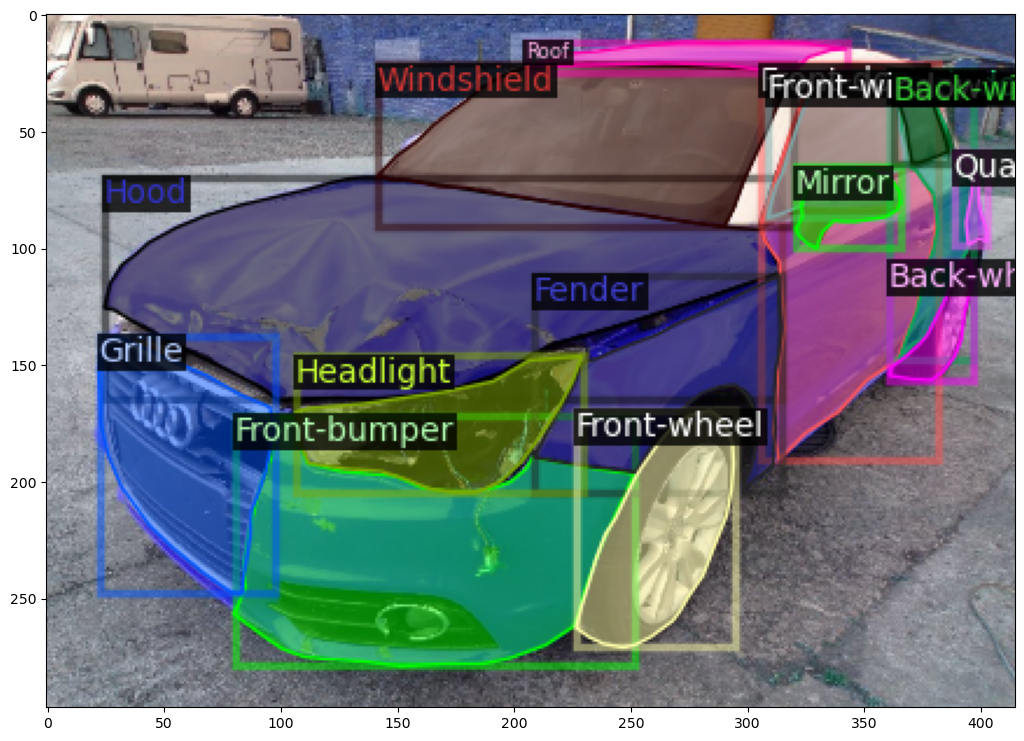

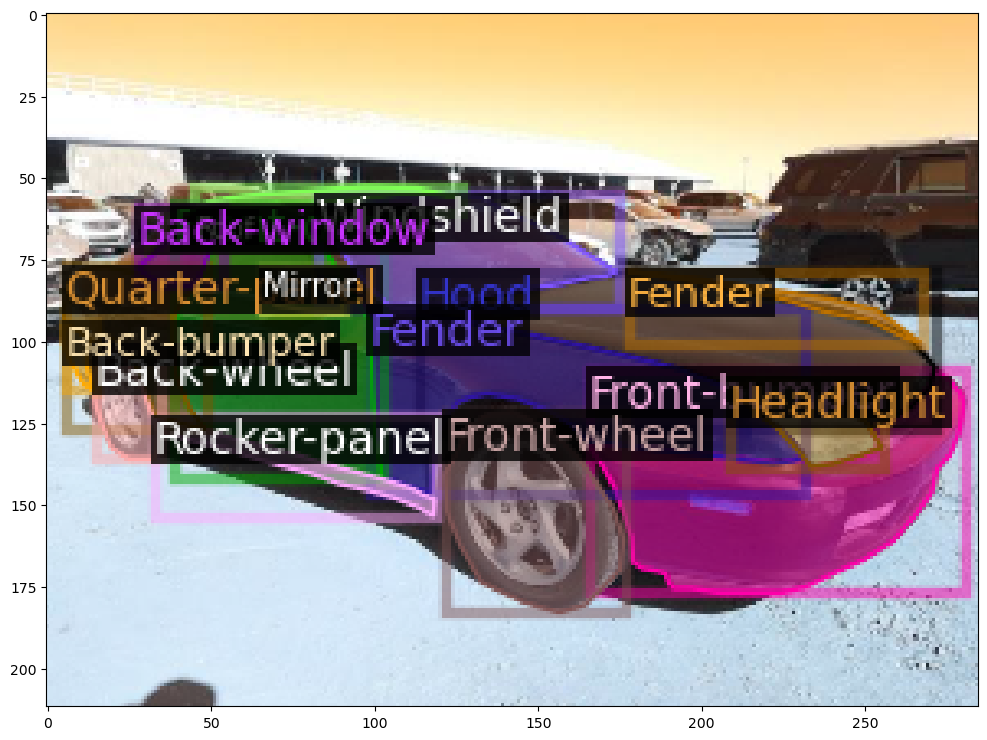

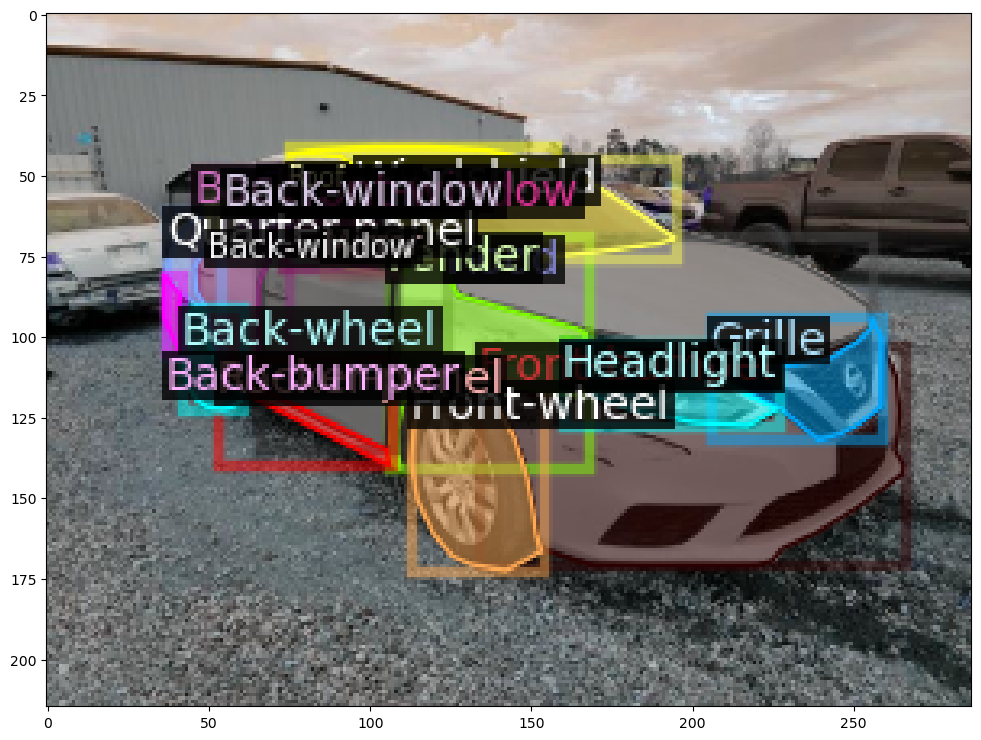

In [4]:
import random
from detectron2.utils.visualizer import Visualizer
from detectron2.data import DatasetCatalog

dataset_dicts = DatasetCatalog.get("car_train")
for d in random.sample(dataset_dicts, 3):
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=car_metadata, scale=0.5)
    vis = visualizer.draw_dataset_dict(d)
    plt.imshow(vis.get_image()[:, :, ::-1])
    plt.show()

In [5]:
import os
import torch
import detectron2
import datetime
from detectron2.engine import DefaultTrainer, hooks, HookBase
from detectron2.config import get_cfg
from detectron2 import model_zoo

# Define output directory
output_dir = "./output_" + datetime.datetime.now().strftime('%Y%m%d_%H%M%S')

# Create configuration
cfg = get_cfg()

# Set output directory
cfg.OUTPUT_DIR = output_dir

# Merge configuration from the model zoo
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))

# Set training and testing datasets
cfg.DATASETS.TRAIN = ("car_train",)
cfg.DATASETS.TEST = ("car_val",)  # for evaluation during training
cfg.DATALOADER.NUM_WORKERS = 4

# Set device to cuda if available
cfg.MODEL.DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

# Set weights from the model zoo
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")  # Let training initialize from model zoo

# Set batch size, learning rate, and maximum iterations
cfg.SOLVER.IMS_PER_BATCH = 8 # before 4
cfg.SOLVER.BASE_LR = 0.00025
cfg.SOLVER.MAX_ITER = 2650  # before 3000
cfg.SOLVER.STEPS = []  # do not decay learning rate

# Set batch size per image and number of classes
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 2   # before 8
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 21  # total number of classes

# Create output directory if it does not exist
os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)

# Custom Trainer to add hooks for status updates
class MyTrainer(DefaultTrainer):
    @classmethod
    def build_evaluator(cls, cfg, dataset_name, output_folder=None):
        from detectron2.evaluation import COCOEvaluator, inference_on_dataset, print_csv_format
        return COCOEvaluator(dataset_name, cfg, False, output_folder)

    def build_hooks(self):
        hooks = super().build_hooks()
        hooks.insert(0, PrintTrainingStatus())
        return hooks

# Custom hook to print training status
class PrintTrainingStatus(HookBase):
    def after_step(self):
        # Print training status every 100 iterations
        if self.trainer.iter % 500 == 0 or self.trainer.iter == self.trainer.max_iter:
            print(f"Iteration {self.trainer.iter}/{self.trainer.max_iter} - Loss: {self.trainer.storage.latest()['total_loss']}")

# Create a trainer
trainer = MyTrainer(cfg)

# Load the model or resume training
trainer.resume_or_load(resume=False)

# Train the model
trainer.train()

[10/27 15:16:27 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

Skip loading parameter 'roi_heads.box_predictor.cls_score.weight' to the model due to incompatible shapes: (81, 1024) in the checkpoint but (22, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.cls_score.bias' to the model due to incompatible shapes: (81,) in the checkpoint but (22,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.weight' to the model due to incompatible shapes: (320, 1024) in the checkpoint but (84, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.bias' to the model due to incompatible shapes: (320,) in the checkpoint but (84,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.mask_head.predictor.weight' to the model due to incompatible shapes: (80, 256, 1, 1) in the checkpoint but (21, 256, 1, 

[10/27 15:16:28 d2.engine.train_loop]: Starting training from iteration 0


C:\Users\kurt_\anaconda3\envs\my-env-detectron2\lib\site-packages\torch\functional.py:513: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\TensorShape.cpp:3610.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


Iteration 0/2650 - Loss: (4.4131570011377335, 0)
[10/27 15:21:58 d2.utils.events]:  eta: 7:56:24  iter: 19  total_loss: 4.984  loss_cls: 3.058  loss_box_reg: 0  loss_mask: 0  loss_rpn_cls: 1.672  loss_rpn_loc: 0.2409    time: 15.9510  last_time: 10.2666  data_time: 0.1825  last_data_time: 0.0116   lr: 4.9953e-06  max_mem: 8047M
[10/27 15:28:40 d2.utils.events]:  eta: 8:50:39  iter: 39  total_loss: 4.367  loss_cls: 2.875  loss_box_reg: 0  loss_mask: 0  loss_rpn_cls: 1.259  loss_rpn_loc: 0.2532    time: 18.1284  last_time: 25.9477  data_time: 0.0108  last_data_time: 0.0066   lr: 9.9902e-06  max_mem: 8048M
[10/27 15:35:10 d2.utils.events]:  eta: 17:31:03  iter: 59  total_loss: 3.434  loss_cls: 2.479  loss_box_reg: 0  loss_mask: 0  loss_rpn_cls: 0.7492  loss_rpn_loc: 0.2158    time: 18.5980  last_time: 10.2104  data_time: 0.0103  last_data_time: 0.0073   lr: 1.4985e-05  max_mem: 8048M
[10/27 15:40:25 d2.utils.events]:  eta: 8:33:15  iter: 79  total_loss: 2.699  loss_cls: 1.863  loss_box_re

In [6]:
import os
import torch
from detectron2.engine import DefaultPredictor  # Import DefaultPredictor

# Set the path to the trained model
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")  # path to the model we just trained
# Set a custom testing threshold
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5

# Create a predictor
predictor = DefaultPredictor(cfg)

[10/28 04:38:39 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from ./output_20241027_151627\model_final.pth ...


C:\Users\kurt_\anaconda3\envs\my-env-detectron2\lib\site-packages\fvcore\common\checkpoint.py:252: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(f, map_loc

In [7]:
import json
import pandas as pd

metrics_path = r"C:\Users\kurt_\car-parts-and-damage-detection-v3\car-part-detection\output_20241027_151627\metrics.json"
metrics_columns = [
    "data_time",
    "eta_seconds",
    "fast_rcnn/cls_accuracy",
    "fast_rcnn/false_negative",
    "fast_rcnn/fg_cls_accuracy",
    "iteration",
    "loss_box_reg",
    "loss_cls",
    "loss_mask",
    "loss_rpn_cls",
    "loss_rpn_loc",
    "lr",
    "mask_rcnn/accuracy",
    "mask_rcnn/false_negative",
    "mask_rcnn/false_positive",
    "rank_data_time",
    "roi_head/num_bg_samples",
    "roi_head/num_fg_samples",
    "rpn/num_neg_anchors",
    "rpn/num_pos_anchors",
    "time",
    "total_loss"
]


data = []
with open(metrics_path, 'r') as f:
    for line in f:
        json_data = json.loads(line)
        filtered_data = {metric: json_data.get(metric, None) for metric in metrics_columns}
        data.append(filtered_data)


In [11]:
df = pd.DataFrame(data)

In [12]:
df

,data_time,eta_seconds,fast_rcnn/cls_accuracy,fast_rcnn/false_negative,fast_rcnn/fg_cls_accuracy,iteration,loss_box_reg,loss_cls,loss_mask,loss_rpn_cls,...,mask_rcnn/accuracy,mask_rcnn/false_negative,mask_rcnn/false_positive,rank_data_time,roi_head/num_bg_samples,roi_head/num_fg_samples,rpn/num_neg_anchors,rpn/num_pos_anchors,time,total_loss
0,0.011181,28584.808292,0.06250,None,None,19,0.0,3.057812,0.0,1.671841,...,None,None,None,0.011181,2.0,0.0,169.3750,86.6250,10.868748,4.984396
1,0.008331,31839.542946,0.34375,None,None,39,0.0,2.874933,0.0,1.258690,...,None,None,None,0.008331,2.0,0.0,167.7500,88.2500,25.515139,4.366842
2,0.008223,63063.039242,0.93750,None,None,59,0.0,2.479050,0.0,0.749214,...,None,None,None,0.008223,2.0,0.0,177.0000,79.0000,25.313738,3.433519
3,0.009559,30795.747170,1.00000,None,None,79,0.0,1.862760,0.0,0.541370,...,None,None,None,0.009559,2.0,0.0,170.1875,85.8125,10.648627,2.698918
4,0.007779,29406.866985,1.00000,None,None,99,0.0,1.087532,0.0,0.335824,...,None,None,None,0.007779,2.0,0.0,166.4375,89.5625,10.861023,1.698705
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
129,0.008266,617.475185,1.00000,None,None,2599,0.0,0.000020,0.0,0.033403,...,None,None,None,0.008266,2.0,0.0,171.0000,85.0000,25.051629,0.159140
130,0.007903,369.468906,1.00000,None,None,2619,0.0,0.000016,0.0,0.030665,...,None,None,None,0.007903,2.0,0.0,170.3125,85.6875,11.418548,0.159593
131,0.008144,122.496867,1.00000,None,None,2639,0.0,0.000033,0.0,0.033894,...,None,None,None,0.008144,2.0,0.0,169.5000,86.5000,11.098252,0.158307
132,0.008272,0.000000,1.00000,None,None,2649,0.0,0.000057,0.0,0.032542,...,None,None,None,0.008272,2.0,0.0,174.3750,81.6250,11.138601,0.162924


In [13]:
# F1 Skoru Hesaplama
# F1 Skoru = 2 * (Precision * Recall) / (Precision + Recall)
# Precision = TP / (TP + FP)
# Recall = TP / (TP + FN)

# Varsayımsal olarak mask_rcnn accuracy ve false negative / positive kullanılarak hesaplama
precision = 1 - df['mask_rcnn/false_positive']
recall = 1 - df['mask_rcnn/false_negative']
f1_score = 2 * (precision * recall) / (precision + recall)
accuracy = df['mask_rcnn/accuracy']

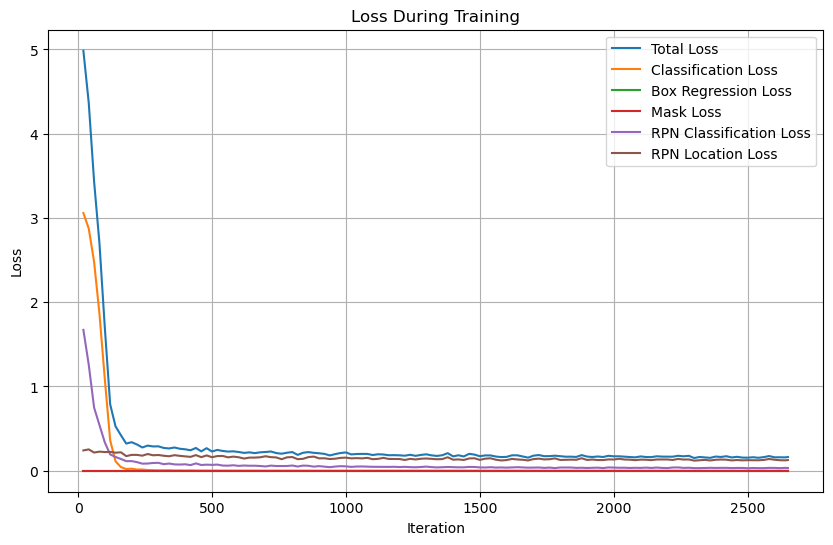

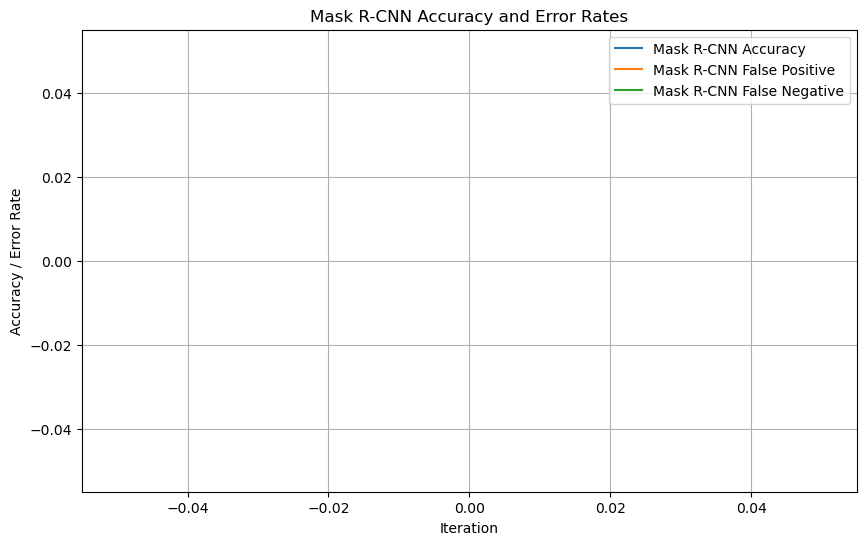

In [14]:
#(Loss) 
plt.figure(figsize=(10, 6))
plt.plot(df['iteration'], df['total_loss'], label='Total Loss')
plt.plot(df['iteration'], df['loss_cls'], label='Classification Loss')
plt.plot(df['iteration'], df['loss_box_reg'], label='Box Regression Loss')
plt.plot(df['iteration'], df['loss_mask'], label='Mask Loss')
plt.plot(df['iteration'], df['loss_rpn_cls'], label='RPN Classification Loss')
plt.plot(df['iteration'], df['loss_rpn_loc'], label='RPN Location Loss')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Loss During Training')
plt.legend()
plt.grid(True)
plt.show()

#  Mask R-CNN Accuracy, False Positive, False Negative 
plt.figure(figsize=(10, 6))
plt.plot(df['iteration'], df['mask_rcnn/accuracy'], label='Mask R-CNN Accuracy')
plt.plot(df['iteration'], df['mask_rcnn/false_positive'], label='Mask R-CNN False Positive')
plt.plot(df['iteration'], df['mask_rcnn/false_negative'], label='Mask R-CNN False Negative')
plt.xlabel('Iteration')
plt.ylabel('Accuracy / Error Rate')
plt.title('Mask R-CNN Accuracy and Error Rates')
plt.legend()
plt.grid(True)
plt.show()